In [1]:
#!/usr/bin/env python3

import pandas as pd
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
from glob import glob
from plumbum.cmd import rm
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os.path
import pickle
import datetime
import re
from keras.models import model_from_json

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plotline(data):
    plt.figure()
    plt.plot(data)
    plt.legend()
    plt.show()

def event_count(time_series, data_name):
    time_series = time_series[['Fill Price (USD)']].values
    upevents = 0
    downevents = 0
    sameprice = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        if obv > prev_obv:
            upevents += 1
        elif obv < prev_obv:
            downevents += 1
        elif obv == prev_obv:
            sameprice += 1
        prev_obv = obv
    print('=== Event counts on %s ===' % data_name)
    print('upevents')
    print(upevents)
    print('downevents')
    print(downevents)
    print('sameprice')
    print(sameprice)
    print()

def mse(time_series, data_name):
    time_series = time_series[['Fill Price (USD)']].values
    total_squared_error = 0
    total_absolute_error = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        total_squared_error += (obv - prev_obv)**2
        total_absolute_error += abs(obv - prev_obv)
        prev_obv = obv
    num_predictions = len(time_series) - 1
    mean_squared_error = total_squared_error / num_predictions
    mean_absolute_error = total_absolute_error / num_predictions
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print('=== baseline on %s ===' % data_name)
    print('total squared error')
    print(total_squared_error)
    print('total absolute error')
    print(total_absolute_error)
    print('mean squared error')
    print(mean_squared_error)
    print('mean absolute error')
    print(mean_absolute_error) 
    print('root mean squared error')
    print(root_mean_squared_error) 
    print()
    
def show_summary_statistics():
    #event_count(small_set, 'small')
    train_set = df.iloc[0:num_samples_training]
    dev_set = df.iloc[num_samples_training:num_samples_training+num_samples_dev]
    test_set = df.iloc[num_samples_training+num_samples_dev:]
    event_count(train_set, 'train')
    event_count(dev_set, 'dev')
    event_count(test_set, 'test')
    mse(train_set, 'train')
    mse(dev_set, 'dev')
    mse(test_set, 'test')
#show_summary_statistics()

In [3]:
def load_data(path, day_start=None, day_end=None):

    # Concatenate dataframes
    files = sorted(glob('%s/*.parquet' % path))
    
    if day_start is not None:
        start = day_start
    else:
        start = 0
    if day_end is not None:
        end = day_start
    else:
        end = len(files)
    files = files[start:end]
    
    all_dataframes = []
    for file in files:
        df = pq.read_table(file).to_pandas()
        all_dataframes.append(df)
    df = pd.concat(all_dataframes)
    return df

In [4]:
def split(df, temporal_features, percent_train):
    X_train, X_dev, X_test, train_prices, dev_prices, test_prices = split_X(df, temporal_features, percent_train)
    Y_train, Y_dev, Y_test = split_Y(df, percent_train)
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test, train_prices, dev_prices, test_prices

In [5]:
def split_X(df, temporal_features, percent_train):
    n_all = df.shape[0]
    n_train = round(n_all * percent_train)
    n_dev   = round(n_all * ((1 - percent_train)/2))
    n_test  = round(n_all * ((1 - percent_train)/2))
    print('n_all:  ', n_all)
    print('n_train:', n_train)
    print('n_dev:  ', n_dev)
    print('n_test: ', n_test)
    
    if temporal_features:
        end = 59
    else:
        end = 16

    X_train = df.iloc[:n_train, 1:end].values.astype('float32')
    X_dev   = df.iloc[n_train:n_train+n_dev, 1:end].values.astype('float32')
    X_test  = df.iloc[n_train+n_dev:, 1:end].values.astype('float32')
    print(X_train.shape)
    print(X_dev.shape)
    print(X_test.shape)
    
    train_prices = df.iloc[:n_train, 0].values.astype('float32')
    dev_prices   = df.iloc[n_train:n_train+n_dev, 0].values.astype('float32')
    test_prices  = df.iloc[n_train+n_dev:, 0].values.astype('float32')

    return X_train, X_dev, X_test, train_prices, dev_prices, test_prices

In [6]:
def split_Y(df, percent_train):
    n_all = df.shape[0]
    n_train = round(n_all * percent_train)
    n_dev   = round(n_all * ((1 - percent_train)/2))
    n_test  = round(n_all * ((1 - percent_train)/2))
    
    Y_train = df.iloc[:n_train, -1:].values.astype('float32')
    Y_dev   = df.iloc[n_train:n_train+n_dev, -1:].values.astype('float32')
    Y_test  = df.iloc[n_train+n_dev:, -1:].values.astype('float32')
    print(Y_train.shape)
    print(Y_dev.shape)
    print(Y_test.shape)
    
    return Y_train, Y_dev, Y_test

In [7]:
def create_end_of_window_Y(Y, window, step):
    # Returns label at the end of a given window
    return np.array([Y[i] for i in range(window-1, len(Y), step)])

In [8]:
def create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test, window_size, step, predict_end_of_window):
    X_train = create_sequenced_data(X_train, window=window_size, step=step)
    X_dev   = create_sequenced_data(X_dev,   window=window_size, step=step)
    X_test  = create_sequenced_data(X_test,  window=window_size, step=step)

    if predict_end_of_window:
        Y_train = create_end_of_window_Y(Y_train, window=window_size, step=step)
        Y_dev   = create_end_of_window_Y(Y_dev,   window=window_size, step=step)
        Y_test  = create_end_of_window_Y(Y_test,  window=window_size, step=step)
    else:
        Y_train = create_sequenced_data(Y_train, window=window_size, step=step)
        Y_dev   = create_sequenced_data(Y_dev,   window=window_size, step=step)
        Y_test  = create_sequenced_data(Y_test,  window=window_size, step=step)
    
    print('Train, dev, test shapes:')
    print(X_train.shape)
    print(X_dev.shape)
    print(X_test.shape)
    print(Y_train.shape)
    print(Y_dev.shape)
    print(Y_test.shape)
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test 

In [9]:
def create_sequenced_data(data, window, step):
    sequenced = []
    for minute in range(0, len(data) - window + 1, step):
        chunk = data[minute:minute+window]
        sequenced.append(chunk)
    sequenced = np.array(sequenced)
    return sequenced

In [10]:
def df_to_parquet(df, outfile):
    pq.write_table(pa.Table.from_pandas(df), outfile, compression='snappy')

In [11]:
def direction_prediction(y_true, y_pred, predict_end_of_window):
    if predict_end_of_window:
        prop_correct = np.sum(np.sign(y_pred) == np.sign(y_true)) / y_true.shape[0]
    else:
        prop_correct = np.sum(np.sign(y_pred) == np.sign(y_true)) / (y_true.shape[0] * y_true.shape[1])
    return prop_correct

In [12]:
def price_diffs(prices, y_hats):
  # Predict within $x of actual price on average
  price_diffs = []
  for i in range(len(prices) - 1):
    current_price       = prices[i]
    percent_change_pred = y_hats[i]
    next_pred_price     = current_price + (current_price * percent_change_pred)
    next_true_price     = prices[i + 1]
    price_diffs.append(np.abs(next_pred_price - next_true_price))
  return price_diffs

In [13]:
# prices = df['current_price']
# train_prices = prices[:len(X_train)]
# dev_prices   = prices[len(X_train):len(X_train)+len(X_dev)]
# test_prices  = prices[len(X_train)+len(X_dev):]

In [14]:
# print(train_prices.shape)
# print(dev_prices.shape)
# print(test_prices.shape)

In [15]:
def initialize_model(X_train, loss, optimizer, num_LSTMs, num_units, dropout, predict_end_of_window):
    
    LSTM_input_shape = [X_train.shape[1], X_train.shape[2]]

    # DEFINE MODEL
    model = Sequential()

    if num_LSTMs == 2:
            model.add(LSTM(num_units[0], input_shape=LSTM_input_shape, return_sequences=True))
            model.add(Dropout(dropout))
            
            if predict_end_of_window:
                model.add(LSTM(num_units[1], return_sequences=False))
            else:
                model.add(LSTM(num_units[1], return_sequences=True))
        
    if num_LSTMs == 3:
            model.add(LSTM(num_units[0], input_shape=LSTM_input_shape, return_sequences=True))
            model.add(Dropout(dropout))

            model.add(LSTM(num_units[1], return_sequences=True))
            model.add(Dropout(dropout))
            
            if predict_end_of_window:
                model.add(LSTM(num_units[2], return_sequences=False))
            else:
                model.add(LSTM(num_units[2], return_sequences=True))

    if predict_end_of_window:
        model.add(Dense(1))
    else:
        model.add(TimeDistributed(Dense(1)))
      
    model.add(Activation('linear'))
    
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [16]:
# # does test_loss == test_loss2?
# test_loss  = model.evaluate(X_test, Y_test, verbose=0)
# y_hat_test  = model.predict(X_test)

In [17]:
# test_loss2 = np.sum((Y_test - y_hat_test)**2) / len(Y_test)
# print(test_loss)
# print(test_loss2)

In [18]:
# print(X_test.shape)
# print(Y_test.shape)
# print(y_hat_test.shape)
# print(test_loss.shape)
# print(test_loss2.shape)

In [19]:
def evaluate_model(model, history, prices, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, 
                   train_prices, dev_prices, test_prices, predict_end_of_window):
  
    train_loss = history.history['loss'][-1]
    dev_loss   = history.history['val_loss'][-1]
    
    print('Evaluating test loss...')
    test_loss  = model.evaluate(X_test, Y_test, verbose=0)
    
    print('Predicting y_hat_train...')
    y_hat_train = model.predict(X_train)
    print('Predicting y_hat_dev...')
    y_hat_dev   = model.predict(X_dev)
    print('Predicting y_hat_test...')
    y_hat_test  = model.predict(X_test)
    
    train_mse, train_rmse = mse_rmse(Y_train, y_hat_train)
    dev_mse,   dev_rmse   = mse_rmse(Y_dev,   y_hat_dev)
    test_mse,  test_rmse  = mse_rmse(Y_test,  y_hat_test)
    
    train_prop_correct = direction_prediction(Y_train, y_hat_train, predict_end_of_window)
    dev_prop_correct   = direction_prediction(Y_dev,   y_hat_dev,   predict_end_of_window)
    test_prop_correct  = direction_prediction(Y_test,  y_hat_test,  predict_end_of_window)
    
    price_diffs_train = price_diffs(train_prices, y_hat_train)
    price_diffs_dev   = price_diffs(dev_prices,   y_hat_dev)
    price_diffs_test  = price_diffs(test_prices,  y_hat_test)
    
    evaluation = {'train_loss': train_loss,
                  'dev_loss':   dev_loss,
                  'test_loss':  test_loss,
                  
                  'train_mse':  train_mse,
                  'train_rmse': train_rmse,
                  'dev_mse':    dev_mse,
                  'dev_rmse':   dev_rmse,
                  'test_mse':   test_mse,
                  'test_rmse':  test_rmse,
                  
                  'train_prop_correct': train_prop_correct,
                  'dev_prop_correct':   dev_prop_correct,
                  'test_prop_correct':  test_prop_correct,
                  
                  'y_hat_train': y_hat_train,
                  'y_hat_dev':   y_hat_dev,
                  'y_hat_test':  y_hat_test}

    return evaluation

In [20]:
def save_model_history(model, history, model_path):
  
    # serialize model to JSON
    if os.path.exists(model_path):
        suffix = ''.join(re.findall(r'\d+', str(datetime.datetime.now())))
        model_path = model_path + '_' + suffix

    os.makedirs(model_path)
    
    model_json = model.to_json()   
    with open(model_path + '/model.json', 'w') as json_file:
        json_file.write(model_json)
    
    try:
      model.save_weights(model_path + '/model.h5')
    except:
      print('WARNING: Could not save weights...')
    
    with open(model_path + '/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
    print("Saved model and history to:\n%s" % model_path)

In [21]:
def plot_price(df, X_train, X_dev, field):
    X_train_stop = len(X_train)
    X_dev_stop = X_train_stop + len(X_dev)

    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0, X_train_stop), df.iloc[0:X_train_stop][field], 'k')
    plt.plot(np.arange(X_train_stop, X_dev_stop), df.iloc[X_train_stop:X_dev_stop][field], 'r')
    plt.plot(np.arange(X_dev_stop, len(df)), df.iloc[X_dev_stop:len(df)][field], 'g')

In [22]:
def plot_train_dev_losses(history):
    train_loss = history.history['loss']
    dev_loss   = history.history['val_loss']
    
    plt.figure(figsize=(20,4))
    plt.plot(np.log(train_loss), 'k')
    
    plt.figure(figsize=(20,4))
    plt.plot(np.log(dev_loss), 'b')
    
    plt.figure(figsize=(20,4))
    plt.plot(train_loss, 'k')
    
    plt.figure(figsize=(20,4))
    plt.plot(dev_loss, 'b')
    
    plt.show()

In [23]:
def plot_percent_change(y_pred, y_true, timestep_within_window, minute_start, minute_end, predict_end_of_window):
    
    ys=[]
    for i in range(len(y_pred)):
        ys.append(y_pred[i][timestep_within_window])

    original_ys=[]
    for i in range(len(y_true)):
        original_ys.append(y_true[i][timestep_within_window])
 
    ys_orig = np.array(original_ys)
    ys_pred = np.array(ys)
    
    OldRange = (ys_pred.max() - ys_pred.min())  
    NewRange = (ys_orig.max() - ys_orig.min())   
    new_ys_pred = (((ys - ys_pred.min()) * NewRange) / OldRange) + ys_orig.min()
    
    norm1 = ys_orig / np.linalg.norm(ys_orig)
    norm2 = ys_pred / np.linalg.norm(ys_pred)
    
    plt.figure(figsize=(20,10))
    plt.plot(norm1[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(norm2[minute_start:minute_end], 'r', alpha=0.9)
    
    plt.figure(figsize=(20,10))
    plt.plot(original_ys[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(ys[minute_start:minute_end], 'r', alpha=0.9)
    
    plt.figure(figsize=(20,10))
    plt.plot(original_ys[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(new_ys_pred[minute_start:minute_end], 'r', alpha=0.9)
    
    try:
        plt.figure(figsize=(20,10))
        plt.plot(y_true[minute_start:minute_end], 'k', alpha=0.9)
        plt.plot(y_pred[minute_start:minute_end], 'r', alpha=0.9)
    except:
        a = 1

In [24]:
def print_save_events_props(train, dev, test, evaluate, model_name, model_path):
    
    train_event_counts = np.unique(np.sign(train), return_counts=True)
    train_event_prop   = train_event_counts[1] / len(train)
    
    dev_event_counts = np.unique(np.sign(dev), return_counts=True)
    dev_event_prop   = dev_event_counts[1] / len(dev)
    
    test_event_counts = np.unique(np.sign(test), return_counts=True)
    test_event_prop   = test_event_counts[1] / len(test)
    
    print(model_name)
    print('\n========== EVENT COUNTS AND PROPORTIONS ==========')
    print('=== TRAIN ===')
    print('Down, Same, Up:', train_event_counts[1])
    print('Down, Same, Up:', train_event_prop)
    
    print('\n=== DEV ===')
    print('Down, Same, Up:', dev_event_counts[1])
    print('Down, Same, Up:', dev_event_prop)
    
    print('\n=== TEST ===')
    print('Down, Same, Up:', test_event_counts[1])
    print('Down, Same, Up:', test_event_prop)
    
    
    print('\n========== CORRECTION DIRECTION PREDICTIONS ==========')
    print("TRAIN: %f\nDEV:   %f\nTEST:  %f" % (evaluate['train_prop_correct'], 
                                               evaluate['dev_prop_correct'], 
                                               evaluate['test_prop_correct']))
    
    print('\n========== FINAL LOSS ==========')
    print("TRAIN: %s\nDEV:   %s\nTEST:  %s\n" % (evaluate['train_loss'], evaluate['dev_loss'], evaluate['test_loss']))   

In [25]:
# def restore_model(path):
#   return model

In [26]:
# def restore_history(path):
#   return history

In [27]:
def plot_losses(history, field, title):
  vals = np.log(restored_history[field])
  #vals = restored_history[field]
  new_df = pd.DataFrame(vals, columns=[field])
  new_df.plot(y = field, figsize=(7,6), title=title, fontsize=14, legend=False, color='firebrick')
  plt.xlabel('Epoch', fontsize=18)
  plt.title(title, fontsize=15, fontweight='bold')

In [28]:
def mse(time_series):
    total_squared_error = 0
    total_absolute_error = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        total_squared_error += (obv - prev_obv)**2
        total_absolute_error += abs(obv - prev_obv)
        prev_obv = obv
    num_predictions = len(time_series) - 1
    mean_squared_error = total_squared_error / num_predictions
    mean_absolute_error = total_absolute_error / num_predictions
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print('=== baseline ===')
    print('total squared error')
    print(total_squared_error)
    print('total absolute error')
    print(total_absolute_error)
    print('mean squared error')
    print(mean_squared_error)
    print('mean absolute error')
    print(mean_absolute_error) 
    print('root mean squared error')
    print(root_mean_squared_error) 
    print()

In [29]:
def mse_rmse(Y_true, Y_pred, verbose=False, baseline_desc=None):
  MSE = np.sum((Y_true - Y_pred) ** 2) / len(Y_true)
  RMSE = np.sqrt(MSE)
  
  if verbose:
    print('\n%s' % baseline_desc)
    print('MSE:  %06f' % MSE)
    print('RMSE: %06f' % RMSE)
  
  return MSE, RMSE

In [30]:
def baselines(Y, data_name):
  print('\n========= %s =========' % data_name)
  Y_true = np.array(Y[1:])
  
  # Predict no percent change
  Y_pred = np.zeros((Y_true.shape))
  mse_rmse(Y_true, Y_pred, verbose=True, baseline_desc='Predict NO Percent Change')
  
  # Predict same percent change
  Y_pred = np.array(Y[:-1])
  mse_rmse(Y_true, Y_pred, verbose=True, baseline_desc='Predict SAME Percent Change')

window-60_step-1_predEndWindow-False_temporalFeat-False_batch-2048_epochs-15_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 15)
(32879, 60, 15)
(32879, 60, 15)
(592823, 60, 1)
(32879, 60, 1)
(32879, 60, 1)


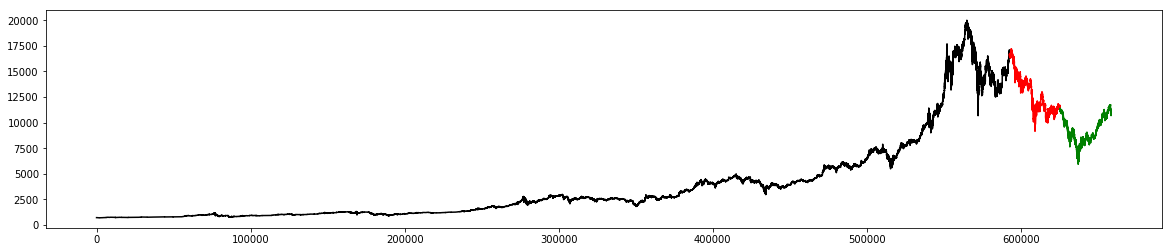

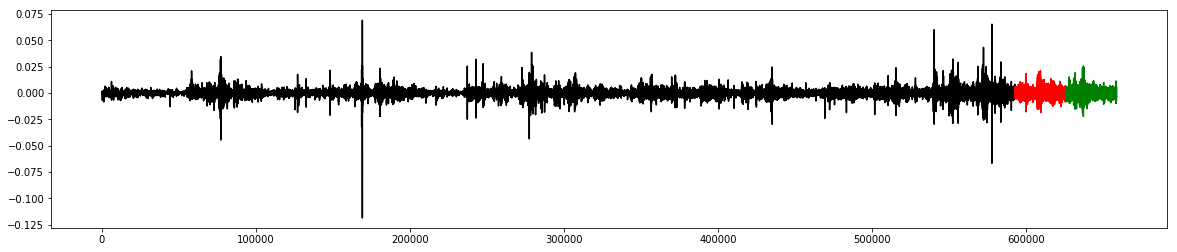

In [31]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = False

batch_size = 2048 #8192
num_epochs = 15
#num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
percent_train = 0.9

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

min_delta = 0.1
patience = 15
early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)
callbacks_list = [early_stop]

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test, train_prices, dev_prices, test_prices = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [32]:
# INITIALIZE MODEL
print('Initializing model...')
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, 
                         predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
print('Training model...')
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), callbacks=callbacks_list, verbose=verbose, shuffle=True) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Initializing model...
Training model...
Train on 592823 samples, validate on 32879 samples
Epoch 1/15
592823/592823 [==============================] - 153s 259us/step - loss: 9.7006e-04 - val_loss: 7.2196e-06
Epoch 2/15
592823/592823 [==============================] - 150s 253us/step - loss: 4.9677e-06 - val_loss: 6.1975e-06
Epoch 3/15
592823/592823 [==============================] - 151s 254us/step - loss: 3.6958e-06 - val_loss: 5.9329e-06
Epoch 4/15
592823/592823 [==============================] - 152s 257us/step - loss: 3.0744e-06 - val_loss: 5.8537e-06
Epoch 5/15
592823/592823 [==============================] - 153s 258us/step - loss: 2.7063e-06 - val_loss: 5.8243e-06
Epoch 6/15
592823/592823 [==============================] - 153s 259us/step - loss: 2.4616e-06 - val_loss: 5.8100e-06
Epoch 7/15
592823/592823 [==============================] - 154s 259us/step - loss: 2.2877e-06 - val_loss: 5.8015e-06
Epoch 8/15
592823/592823 [==============================] - 154s 260us/step - loss:

In [ ]:
# EVALUATE MODEL
print('Evaluating model...')
prices = df['current_price']
evaluate = evaluate_model(model, history, prices, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

with open(model_path + '/evaluate.pkl', 'wb') as f:
  pickle.dump(evaluate, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
    timestep_within_window = 0
else:
    timestep_within_window = window-1
    
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

plot_losses(restored_history, field='loss', title='Training Loss')
plot_losses(restored_history, field='val_loss', title='Dev Loss')

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [ ]:
# # Plot train and dev loss for each saved model
# paths = sorted(glob('models/*'))
## file = 'models/window-60_step-1_predEndWindow-False_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None'
# for path in paths:
#   file = path
#   restored_history = pickle.load( open( file+"/trainHistoryDict", "rb" ) )
#   plot_losses(restored_history, field='loss', title='Training Loss\n%s' % file)
#   plot_losses(restored_history, field='val_loss', title='Dev Loss\n%s' % file)

In [37]:
print('================== BASELINES ==================')
baselines(Y_train, data_name='Training Data')
baselines(Y_dev,   data_name='Dev Data')
baselines(Y_test,  data_name='Test Data')

================== BASELINES ==================

========= Training Data =========

Predict NO Percent Change
MSE:  0.000100
RMSE: 0.009992

Predict SAME Percent Change
MSE:  0.000181
RMSE: 0.013446

========= Dev Data =========

Predict NO Percent Change
MSE:  0.000347
RMSE: 0.018626

Predict SAME Percent Change
MSE:  0.000716
RMSE: 0.026765

========= Test Data =========

Predict NO Percent Change
MSE:  0.000351
RMSE: 0.018742

Predict SAME Percent Change
MSE:  0.000745
RMSE: 0.027288


In [ ]:
#per row: train, dev, test loss
losss = np.array([[1.690e-6, 5.907e-6, 5.893e-6],
[1.673e-6, 5.79e-6, 5.865e-6],
[1.925e-6, 1.043e-5, 1.18e-6],
[1.959e-6, 5.909e-6, 5.97e-6],
[1.694e-6, 6.255e-6, 6.31e-6],
[1.799e-6, 5.791e-6, 5.94e-6],
[1.822e-6, 1.00e-5, 1.09e-5],
[1.718e-5, 6.934e-5, 6.988e-5]])
np.sqrt(np.array([1.673e-6, 5.79e-6, 5.865e-6]))
np.sqrt(losss.mean(axis=0, keepdims=True))

window-60_step-1_predEndWindow-False_temporalFeat-False_batch-1024_epochs-15_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 15)
(32879, 60, 15)
(32879, 60, 15)
(592823, 60, 1)
(32879, 60, 1)
(32879, 60, 1)


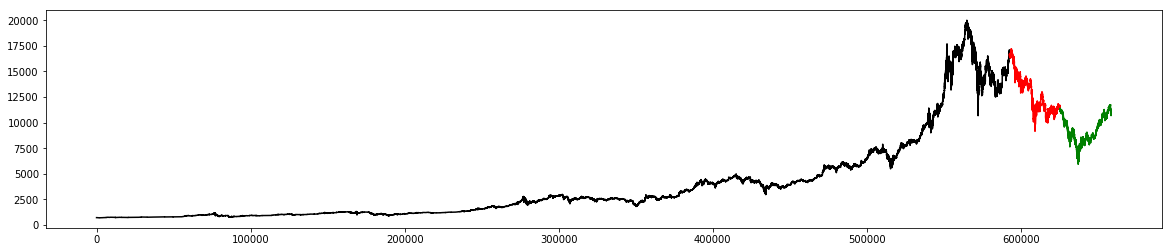

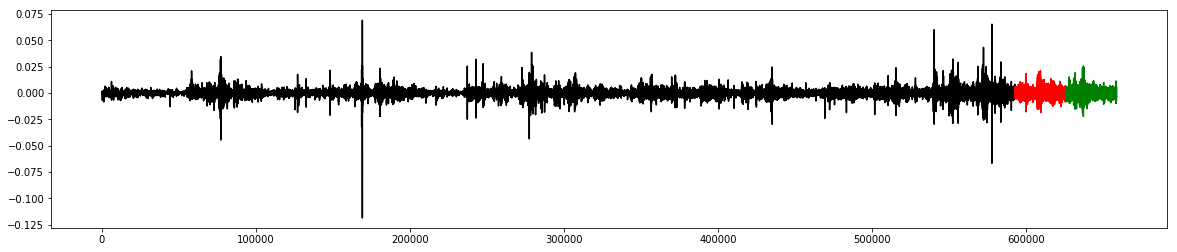

In [38]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = False

batch_size2 = 1024 #8192
num_epochs = 15
#num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
percent_train = 0.9

num_units_string = '-'.join([str(u) for u in num_units])

model_name2 = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size2, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name2+'\n')
model_path2 = 'models/%s' % model_name2  

min_delta = 0.1
patience = 15
early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)
callbacks_list = [early_stop]

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test, train_prices, dev_prices, test_prices = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [39]:
# INITIALIZE MODEL
print('Initializing model...')
model2 = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, 
                         predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
print('Training model...')
history2 = model.fit(X_train, Y_train, batch_size=batch_size2, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), callbacks=callbacks_list, verbose=verbose, shuffle=True) 

# SAVE MODEL AND HISTORY
save_model_history(model2, history2, model_path2)

Initializing model...
Training model...
Train on 592823 samples, validate on 32879 samples
Epoch 1/15
592823/592823 [==============================] - 169s 285us/step - loss: 1.7089e-06 - val_loss: 5.7875e-06
Epoch 2/15
592823/592823 [==============================] - 171s 288us/step - loss: 1.6972e-06 - val_loss: 5.7866e-06
Epoch 3/15
592823/592823 [==============================] - 172s 290us/step - loss: 1.7118e-06 - val_loss: 5.7906e-06
Epoch 4/15
592823/592823 [==============================] - 172s 290us/step - loss: 1.7088e-06 - val_loss: 5.7873e-06
Epoch 5/15
592823/592823 [==============================] - 172s 290us/step - loss: 1.7110e-06 - val_loss: 5.8938e-06
Epoch 6/15
592823/592823 [==============================] - 173s 291us/step - loss: 1.7098e-06 - val_loss: 5.8428e-06
Epoch 7/15
592823/592823 [==============================] - 173s 291us/step - loss: 1.7075e-06 - val_loss: 5.7932e-06
Epoch 8/15
592823/592823 [==============================] - 173s 292us/step - loss:

In [ ]:
# # EVALUATE MODEL
# print('Evaluating model...')
# prices = df['current_price']
# evaluate2 = evaluate_model(model2, history2, prices, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

# with open(model_path2 + '/evaluate.pkl', 'wb') as f:
#   pickle.dump(evaluate2, f, pickle.HIGHEST_PROTOCOL)

In [42]:
train_loss = history.history['loss'][-1]
dev_loss   = history.history['val_loss'][-1]
print(train_loss)
print(dev_loss)

1.7926928531517364e-06
5.789546197679453e-06


In [43]:
train_loss2 = history2.history['loss'][-1]
dev_loss2   = history2.history['val_loss'][-1]
print(train_loss)
print(dev_loss)

1.6857532802722535e-06
5.800672820539064e-06


In [44]:
print('Evaluating test loss...')
test_loss2  = model2.evaluate(X_test, Y_test, batch_size=batch_size2, verbose=0)

Evaluating test loss...


In [173]:
np.sqrt(test_loss2)

0.016264546337388247

In [48]:
print('Predicting y_hat_train...')
y_hat_train2 = model2.predict(X_train, batch_size=batch_size2)
print('Predicting y_hat_dev...')
y_hat_dev2   = model2.predict(X_dev,  batch_size=batch_size2)
print('Predicting y_hat_test...')
y_hat_test2  = model2.predict(X_test, batch_size=batch_size2)

Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


(592823, 1)
(592823, 1)
0.239648259261196
(592823,)
592822
592822


array([[1.        , 0.15650905],
       [0.15650905, 1.        ]])

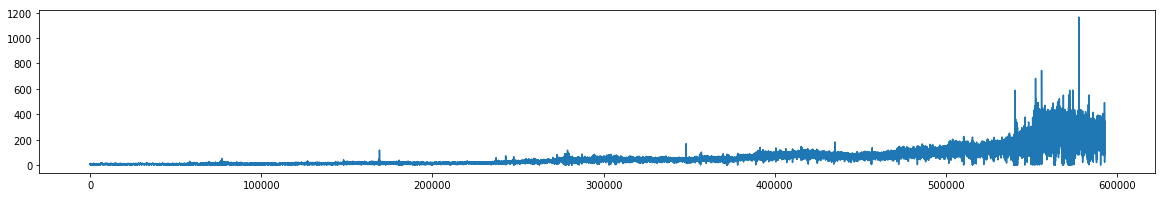

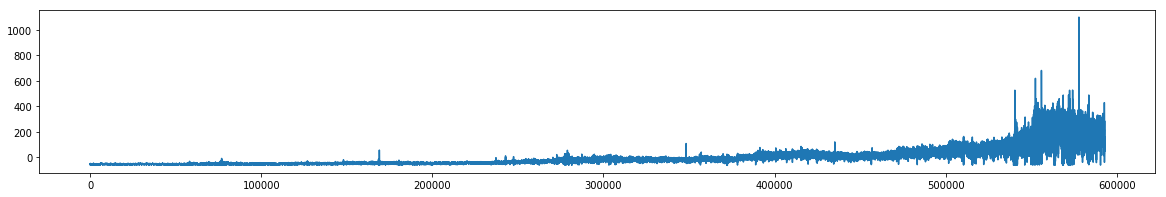

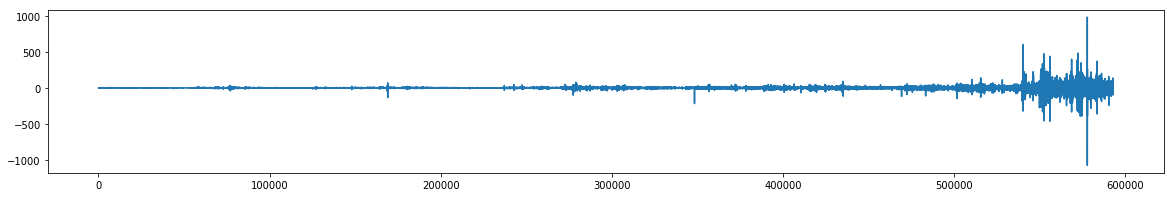

In [144]:
# TRAIN
window = window_size
Y_pred = y_hat_train2[:, window-1]
Y_true = Y_train[:, window-1]
prices = train_prices

print(Y_pred_train.shape)
print(Y_true.shape)
prop_correct  = direction_prediction(Y_true,  Y_pred,  predict_end_of_window)
print(prop_correct)
print(prices[window-1:].shape)
price_diffs_vec = price_diffs(prices[window-1:], Y_pred)
print(len(price_diffs_vec))

price_diffs_predSAME = prices[window:]-prices[window-1:-1]
print(len(price_diffs_predSAME))

plt.figure(figsize=[20,3])
plt.plot(price_diffs_vec)
plt.figure(figsize=[20,3])
plt.plot(price_diffs_vec-np.mean(price_diffs_vec))
plt.figure(figsize=[20,3])
plt.plot(price_diffs_predSAME)

np.corrcoef(np.array(price_diffs_vec)[:,0], price_diffs_predSAME)

In [171]:
# TEST
Y_pred = y_hat_test2[:, 59]
Y_true = Y_test[:, 59]
print(Y_pred.shape)
print(Y_true.shape)
test_prop_correct  = direction_prediction(Y_true,  Y_pred,  predict_end_of_window)
print(test_prop_correct)
len(Y_pred)
print(test_prices[59:].shape)
price_diffs_test = price_diffs(test_prices[59:], Y_pred)
print(len(price_diffs_test))

price_diffs_predSAME = test_prices[60:]-test_prices[59:-1]
print(len(price_diffs_predSAME))

# plt.figure(figsize=[20,3])
# plt.plot(price_diffs_test)
# plt.figure(figsize=[20,3])
# plt.plot(price_diffs_test-np.mean(price_diffs_test))
# plt.figure(figsize=[20,3])
# plt.plot(price_diffs_test-np.mean(price_diffs_vec))
# plt.figure(figsize=[20,3])
# plt.plot(price_diffs_predSAME)
#np.corrcoef(np.array(price_diffs_test)[:,0], price_diffs_predSAME)

print(np.corrcoef(price_diffs_predSAME, test_prices[60:]))
print(np.corrcoef(np.array(price_diffs_test)[:,0], test_prices[60:]))

(32879, 1)
(32879, 1)
0.4521731196204264
(32879,)
32878
32878
[[1.         0.00726156]
 [0.00726156 1.        ]]
[[1.         0.57122106]
 [0.57122106 1.        ]]


In [157]:
len(price_diffs_vec)

592822

In [162]:
len(prices[60:])

592822

In [ ]:
mse_train, rmse_train = mse_rmse(Y_train, y_hat_train)
#mse_dev,   rmse_dev   = mse_rmse(Y_dev,   y_hat_dev)
#mse_test,  rmse_test  = mse_rmse(Y_test,  y_hat_test)

In [ ]:
train_prop_correct = direction_prediction(Y_train, y_hat_train, predict_end_of_window)
dev_prop_correct   = direction_prediction(Y_dev,   y_hat_dev,   predict_end_of_window)
test_prop_correct  = direction_prediction(Y_test,  y_hat_test,  predict_end_of_window)

price_diffs_train = price_diffs(train_prices, y_hat_train)
price_diffs_dev   = price_diffs(dev_prices,   y_hat_dev)
price_diffs_test  = price_diffs(test_prices,  y_hat_test)
    
evaluation = {'train_loss': train_loss,
              'dev_loss':   dev_loss,
              'test_loss':  test_loss,

              'train_mse':  train_mse,
              'train_rmse': train_rmse,
              'dev_mse':    dev_mse,
              'dev_rmse':   dev_rmse,
              'test_mse':   test_mse,
              'test_rmse':  test_rmse,

              'train_prop_correct': train_prop_correct,
              'dev_prop_correct':   dev_prop_correct,
              'test_prop_correct':  test_prop_correct,

              'y_hat_train': y_hat_train,
              'y_hat_dev':   y_hat_dev,
              'y_hat_test':  y_hat_test}

window-60_step-1_predEndWindow-False_temporalFeat-False_batch-1024_epochs-15_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 15)
(32879, 60, 15)
(32879, 60, 15)
(592823, 60, 1)
(32879, 60, 1)
(32879, 60, 1)


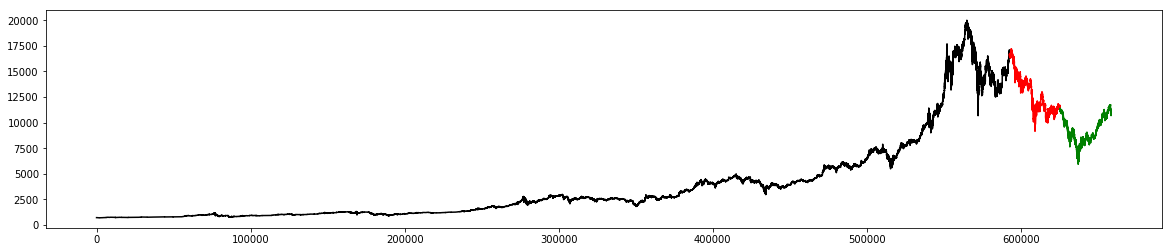

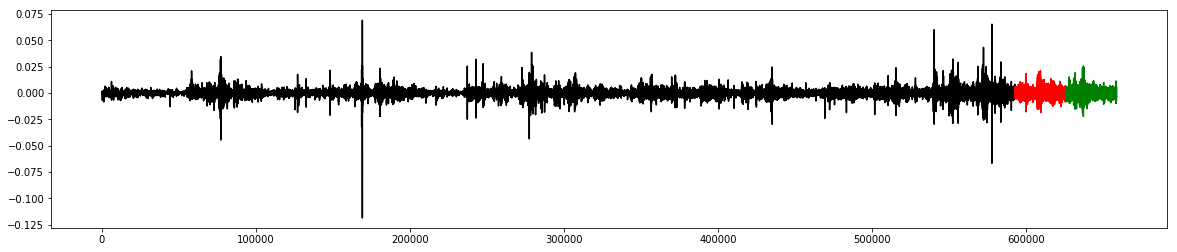

In [176]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = False

batch_size2 = 1024 #8192
num_epochs = 15
#num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
percent_train = 0.9

num_units_string = '-'.join([str(u) for u in num_units])

model_name2 = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size2, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name2+'\n')
model_path2 = 'models/%s' % model_name2  

min_delta = 0.1
patience = 15
early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)
callbacks_list = [early_stop]

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test, train_prices, dev_prices, test_prices = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [180]:
np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1]).shape

(592823, 60, 1)

window-60_step-1_predEndWindow-False_temporalFeat-False_batch-2048_epochs-5_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 15)
(32879, 60, 15)
(32879, 60, 15)
(592823, 60, 1)
(32879, 60, 1)
(32879, 60, 1)
(592823, 60, 1) (32879, 60, 1) (32879, 60, 1)


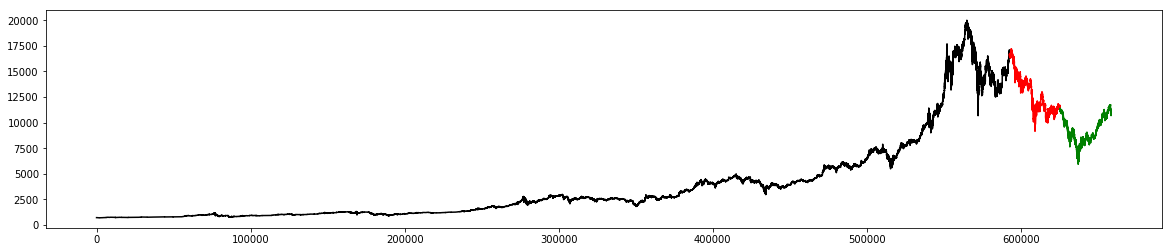

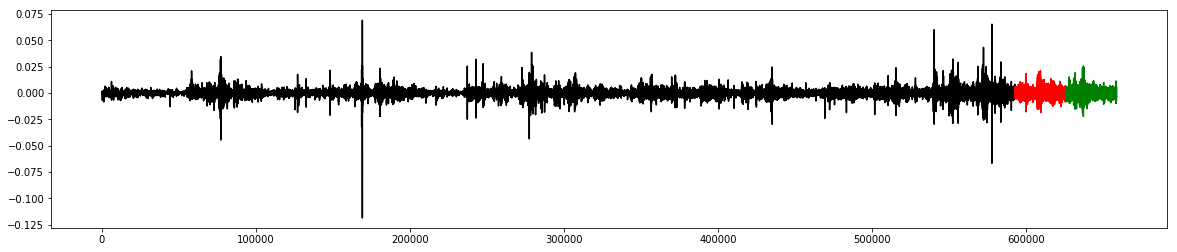

In [210]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = False

batch_size2 = 2048 #8192
num_epochs = 5
#num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
percent_train = 0.9

num_units_string = '-'.join([str(u) for u in num_units])

model_name3 = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size2, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name3+'\n')
model_path3 = 'models/%s' % model_name3  

min_delta = 0.1
patience = 15
early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)
callbacks_list = [early_stop]

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test, train_prices, dev_prices, test_prices = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

X_train = np.array(X_train[:,:,0])
X_dev = np.array(X_dev[:,:,0])
X_test = np.array(X_test[:,:,0])
X_train = np.array(np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1]))
X_dev = np.array(np.reshape(X_dev, [X_dev.shape[0], X_dev.shape[1], 1]))
X_test = np.array(np.reshape(X_test, [X_test.shape[0], X_test.shape[1], 1]))
print(X_train.shape, X_dev.shape, X_test.shape)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [212]:
# INITIALIZE MODEL
print('Initializing model...')
model3 = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, 
                         predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
print('Training model...')
history3 = model3.fit(X_train, Y_train, batch_size=batch_size2, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), callbacks=callbacks_list, verbose=verbose, shuffle=True) 

# SAVE MODEL AND HISTORY
save_model_history(model3, history3, model_path3)

Initializing model...
Training model...
Train on 592823 samples, validate on 32879 samples
Epoch 1/5
592823/592823 [==============================] - 147s 249us/step - loss: 4.6967e-06 - val_loss: 5.7824e-06
Epoch 2/5
592823/592823 [==============================] - 147s 248us/step - loss: 1.6645e-06 - val_loss: 5.7823e-06
Epoch 3/5
592823/592823 [==============================] - 148s 249us/step - loss: 1.6644e-06 - val_loss: 5.7822e-06
Epoch 4/5
592823/592823 [==============================] - 149s 252us/step - loss: 1.6643e-06 - val_loss: 5.7823e-06
Epoch 5/5
592823/592823 [==============================] - 150s 253us/step - loss: 1.6643e-06 - val_loss: 5.7822e-06
Saved model and history to:
models/window-60_step-1_predEndWindow-False_temporalFeat-False_batch-2048_epochs-5_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None


In [213]:
np.sqrt(5.865e-6)

0.0024217762076624667